In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
import numpy as np
import pandas as pd

In [4]:
dataset = pd.read_csv('combined_data.csv')

sentences = dataset['text'].tolist()
labels = dataset['sentiment'].tolist()

In [5]:
import tensorflow_datasets as tfds

vocab_size = 1000
tokenizer = tfds.features.text.SubwordTextEncoder.build_from_corpus(sentences, vocab_size, max_subword_length=5)
print("Vocab size is ", tokenizer.vocab_size)

Vocab size is  999


In [7]:
for i , sentence in enumerate(sentences):
    sentences[i] = tokenizer.encode(sentence)

In [8]:
print(sentences[5])

[4, 31, 6, 849, 162, 450, 12, 1, 600, 438, 775, 6, 175, 14, 6, 55, 213, 159, 474, 775, 6, 175, 614, 380, 295, 148, 72, 789]


In [18]:
max_len = 50 
padding_type = 'post'
trunc_type = 'post'

sequences_padded = pad_sequences(sentences, maxlen=max_len, 
                                 padding=padding_type, truncating=trunc_type)

In [19]:
training_size = int(len(sentences) * 0.8)

training_sequences = sequences_padded[0:training_size]
testing_sequences = sequences_padded[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

# Make labels into numpy arrays for use with the network later
training_labels_final = np.array(training_labels)
testing_labels_final = np.array(testing_labels)

In [20]:
embedding_dim = 16

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_len),
    tf.keras.layers.GlobalAveragePooling1D(), 
    tf.keras.layers.Dense(6, activation = 'relu'),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
]
)

In [21]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 16)            16000     
_________________________________________________________________
global_average_pooling1d_1 ( (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 102       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 7         
Total params: 16,109
Trainable params: 16,109
Non-trainable params: 0
_________________________________________________________________


In [22]:
num_epochs = 30
model.compile(optimizer = 'adam',
              loss = 'binary_crossentropy',
              metrics = ['accuracy']
             )
history = model.fit(training_sequences, 
                    training_labels_final, 
                    epochs = num_epochs,
                    validation_data= (testing_sequences, testing_labels_final)
                   )

Train on 1593 samples, validate on 399 samples
Epoch 1/30
1593/1593 [==============================] - 1s 420us/sample - loss: 0.6926 - accuracy: 0.5248 - val_loss: 0.6956 - val_accuracy: 0.4135
Epoch 2/30
1593/1593 [==============================] - 0s 62us/sample - loss: 0.6905 - accuracy: 0.5424 - val_loss: 0.6939 - val_accuracy: 0.4637
Epoch 3/30
1593/1593 [==============================] - 0s 56us/sample - loss: 0.6864 - accuracy: 0.5876 - val_loss: 0.6920 - val_accuracy: 0.4937
Epoch 4/30
1593/1593 [==============================] - 0s 67us/sample - loss: 0.6793 - accuracy: 0.6359 - val_loss: 0.6847 - val_accuracy: 0.5564
Epoch 5/30
1593/1593 [==============================] - 0s 56us/sample - loss: 0.6683 - accuracy: 0.6742 - val_loss: 0.6735 - val_accuracy: 0.6391
Epoch 6/30
1593/1593 [==============================] - 0s 68us/sample - loss: 0.6525 - accuracy: 0.7288 - val_loss: 0.6616 - val_accuracy: 0.6566
Epoch 7/30
1593/1593 [==============================] - 0s 60us/sample

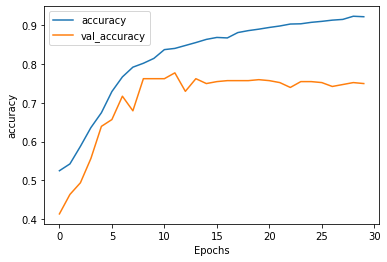

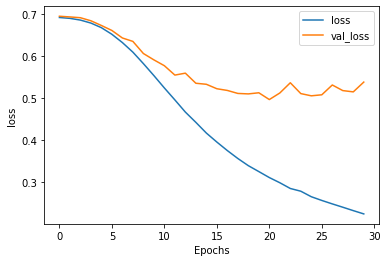

In [23]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [27]:
def predict_review(model, new_sentences, maxlen=max_len, show_padded_sequence=True ):
    new_sequences = []

    for i, frvw in enumerate(new_sentences):
        new_sequences.append(tokenizer.encode(frvw))

    trunc_type='post' 
    padding_type='post'

    new_reviews_padded = pad_sequences(new_sequences, maxlen=max_len, 
                                 padding=padding_type, truncating=trunc_type)             

    classes = model.predict(new_reviews_padded)

    for x in range(len(new_sentences)):

        if (show_padded_sequence):
            print(new_reviews_padded[x])
        print(new_sentences[x])
        print(classes[x])
        print("\n")

In [28]:
fake_reviews = ["I love this phone", 
                "Everything was cold",
                "Everything was hot exactly as I wanted", 
                "Everything was green", 
                "the host seated us immediately",
                "they gave us free chocolate cake", 
                "we couldn't hear each other talk because of the shouting in the kitchen"
              ]

predict_review(model, fake_reviews)

[  4 281  16  25   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
I love this phone
[0.86505383]


[812 227 864 100 775   9 525 843   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
Everything was cold
[0.21167581]


[812 227 864 100 775   9 109   8 333 731  24  61   4 171  59  77   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
Everything was hot exactly as I wanted
[0.3099107]


[812 227 864 100 775   9 157 359 853   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
Everything was green
[0.15588082]


[  1 109 228 540 237 635 24

In [29]:
def fit_model_now (model, sentences) :
    model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
    model.summary()
    history = model.fit(training_sequences, training_labels_final, epochs=num_epochs, 
                      validation_data=(testing_sequences, testing_labels_final))
    return history

def plot_results (history):
    plot_graphs(history, "accuracy")
    plot_graphs(history, "loss")

def fit_model_and_show_results (model, sentences):
    history = fit_model_now(model, sentences)
    plot_results(history)
    predict_review(model, sentences)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 50, 16)            16000     
_________________________________________________________________
bidirectional (Bidirectional (None, 32)                4224      
_________________________________________________________________
dense_4 (Dense)              (None, 6)                 198       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 7         
Total params: 20,429
Trainable params: 20,429
Non-trainable params: 0
_________________________________________________________________
Train on 1593 samples, validate on 399 samples
Epoch 1/30
1593/1593 [==============================] - 5s 3ms/sample - loss: 0.6932 - accuracy: 0.4846 - val_loss: 0.6931 - val_accuracy: 0.4662
Epoch 2/30
1593/1593 [==============================] -

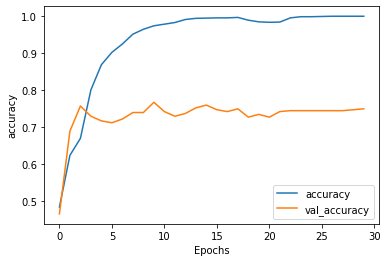

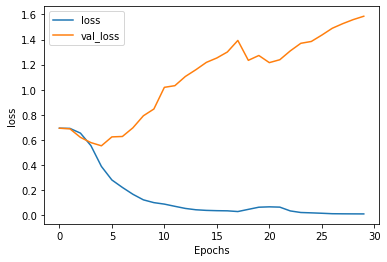

[  4 281  16  25   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
I love this phone
[0.9954531]


[812 227 864 100 775   9 525 843   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
Everything was cold
[4.224979e-05]


[812 227 864 100 775   9 109   8 333 731  24  61   4 171  59  77   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
Everything was hot exactly as I wanted
[0.9937137]


[812 227 864 100 775   9 157 359 853   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
Everything was green
[0.00891936]


[  1 109 228 540 237 635 2

In [31]:
model_bidi_lstm = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_len),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim)), 
    tf.keras.layers.Dense(6, activation='relu'), 
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile and train the model and then show the predictions for our extra sentences
fit_model_and_show_results(model_bidi_lstm, fake_reviews)


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 50, 16)            16000     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 50, 32)            4224      
_________________________________________________________________
bidirectional_2 (Bidirection (None, 32)                6272      
_________________________________________________________________
dense_6 (Dense)              (None, 6)                 198       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 7         
Total params: 26,701
Trainable params: 26,701
Non-trainable params: 0
_________________________________________________________________
Train on 1593 samples, validate on 399 samples
Epoch 1/30
1593/1593 [==============================] - 8s 5ms/sample

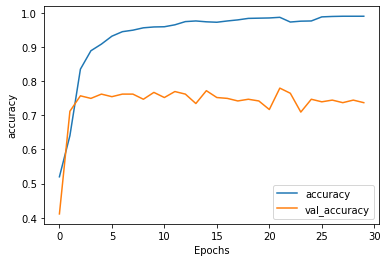

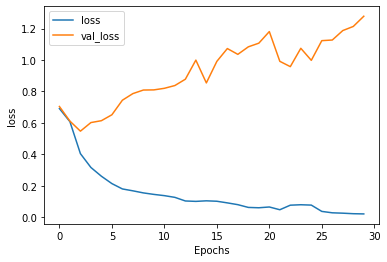

[  4 281  16  25   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
I love this phone
[0.9988427]


[812 227 864 100 775   9 525 843   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
Everything was cold
[0.00209102]


[812 227 864 100 775   9 109   8 333 731  24  61   4 171  59  77   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
Everything was hot exactly as I wanted
[0.00215756]


[812 227 864 100 775   9 157 359 853   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
Everything was green
[0.00251982]


[  1 109 228 540 237 635 24

In [33]:
model_multiple_bidi_lstm = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_len),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim, 
                                                       return_sequences=True)), 
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim)),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

fit_model_and_show_results(model_multiple_bidi_lstm, fake_reviews)

In [38]:
my_reviews =["lovely", "dreadful", "stay away",
             "everything was hot exactly as I wanted",
             "everything was not exactly as I wanted",
             "they gave us free chocolate cake",
             "I've never eaten anything so spicy in my life, my throat burned for hours",
             "for a phone that is as expensive as this one I expect it to be much easier to use than this thing is",
             "we left there very full for a low price so I'd say you just can't go wrong at this place",
             "that place does not have quality meals and it isn't a good place to go for dinner",
             "This was not a waste of time at all",
             ]

In [39]:
print("===================================\n","Embeddings only:\n", "===================================",)
predict_review(model, my_reviews, show_padded_sequence=False)

 Embeddings only:
lovely
[0.88503855]


dreadful
[0.46478623]


stay away
[0.6858186]


everything was hot exactly as I wanted
[0.642535]


everything was not exactly as I wanted
[0.4597507]


they gave us free chocolate cake
[0.70615107]


I've never eaten anything so spicy in my life, my throat burned for hours
[0.04757803]


for a phone that is as expensive as this one I expect it to be much easier to use than this thing is
[0.5628118]


we left there very full for a low price so I'd say you just can't go wrong at this place
[0.7804147]


that place does not have quality meals and it isn't a good place to go for dinner
[0.7877849]


This was not a waste of time at all
[0.01243377]




In [40]:
print("===================================\n", "With a single bidirectional LSTM:\n", "===================================")
predict_review(model_bidi_lstm, my_reviews, show_padded_sequence=False)

 With a single bidirectional LSTM:
lovely
[0.99428976]


dreadful
[0.00842947]


stay away
[0.30759808]


everything was hot exactly as I wanted
[0.9946831]


everything was not exactly as I wanted
[0.8757534]


they gave us free chocolate cake
[0.44906592]


I've never eaten anything so spicy in my life, my throat burned for hours
[0.010416]


for a phone that is as expensive as this one I expect it to be much easier to use than this thing is
[0.99617046]


we left there very full for a low price so I'd say you just can't go wrong at this place
[0.9957925]


that place does not have quality meals and it isn't a good place to go for dinner
[0.99143606]


This was not a waste of time at all
[1.5514367e-07]




In [41]:
print("===================================\n","With two bidirectional LSTMs:\n", "===================================")
predict_review(model_multiple_bidi_lstm, my_reviews, show_padded_sequence=False)

 With two bidirectional LSTMs:
lovely
[0.99867827]


dreadful
[0.00335579]


stay away
[0.00336212]


everything was hot exactly as I wanted
[0.90019554]


everything was not exactly as I wanted
[0.00321327]


they gave us free chocolate cake
[0.99820125]


I've never eaten anything so spicy in my life, my throat burned for hours
[0.01520504]


for a phone that is as expensive as this one I expect it to be much easier to use than this thing is
[0.00461772]


we left there very full for a low price so I'd say you just can't go wrong at this place
[0.9922854]


that place does not have quality meals and it isn't a good place to go for dinner
[0.00327008]


This was not a waste of time at all
[0.00517496]


